In [1]:
from kaggle.api.kaggle_api_extended import KaggleApi
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn.mixture import GaussianMixture as GMM
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error,mean_absolute_error
from sklearn.model_selection import cross_val_score

import xgboost as xgb
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression


import optuna

import joblib

#本工程中所有随机种子均取111
seed = 111

In [5]:
 #使用kaggle的api接口下载数据
!kaggle datasets download -d zhudig123/airbnb-dataset-from-group-7 --unzip -w --force -q

## 第一部分：特征工程
#### （1）数据集概览

In [6]:
data = pd.read_csv('final_exam_data.csv')
data.head()

listing_id  price(dollar)  \
0      281420        62.4923   
1     3705183       141.4920   
2     4082273       104.9399   
3     4797344        68.3878   
4     4823489        70.7460   

                                               name   host_id  host_since  \
0    Beautiful Flat in le Village Montmartre, Paris   1466919  2011-12-03   
1                   39 mÃÂ² Paris (Sacre CÃ
âur)  10328771  2013-11-29   
2               Lovely apartment with Terrace, 60m2  19252768  2014-07-31   
3               Cosy studio (close to Eiffel tower)  10668311  2013-12-17   
4  Close to Eiffel Tower - Beautiful flat : 2 rooms  24837558  2014-12-14   

   host_duration                 host_location host_response_time  \
0           3543  Paris, Ile-de-France, France     within an hour   
1           2816  Paris, Ile-de-France, France     within an hour   
2           2572  Paris, Ile-de-France, France     within an hour   
3           2798  Paris, Ile-de-France, France     within an hour   
4           2436  Paris, Ile-de-France, France     within an hour   

   host_response_rate  host_acceptance_rate  ...  Rio de Janeiro   Rome  \
0                 1.0                   1.0  ...           False  False   
1                 1.0                   1.0  ...           False  False   
2                 1.0                   1.0  ...           False  False   
3                 1.0                   1.0  ...           False  False   
4                 1.0                   1.0  ...           False  False   

   Sydney  Hotel room Private room Shared room  instant_bookable_t  \
0   False       False        False       False                True   
1   False       False        False       False                True   
2   False       False        False       False                True   
3   False       False        False       False                True   
4   False       False        False       False                True   

   instant_bookable_f  distance  \
0               False  0.827539   
1               False  0.801189   
2               False  0.810585   
3               False  0.528713   
4               False  0.676304   

                                           amenities  
0  ["Heating", "Kitchen", "Washer", "Wifi", "Long...  
1  ["Shampoo", "Heating", "Kitchen", "Essentials"...  
2  ["Heating", "TV", "Kitchen", "Washer", "Wifi",...  
3  ["Heating", "TV", "Kitchen", "Wifi", "Long ter...  
4  ["Heating", "TV", "Kitchen", "Essentials", "Ha...  

[5 rows x 51 columns]

In [31]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 274034 entries, 0 to 274033
Data columns (total 51 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   listing_id                   274034 non-null  int64  
 1   price(dollar)                274034 non-null  float64
 2   name                         274034 non-null  object 
 3   host_id                      274034 non-null  int64  
 4   host_since                   274034 non-null  object 
 5   host_duration                274034 non-null  int64  
 6   host_location                274034 non-null  object 
 7   host_response_time           274034 non-null  object 
 8   host_response_rate           274034 non-null  float64
 9   host_acceptance_rate         274034 non-null  float64
 10  host_is_superhost            274034 non-null  bool   
 11  host_total_listings_count    274034 non-null  float64
 12  host_has_profile_pic         274034 non-null  bool   
 13 

In [32]:
#由于‘host_response_time’的排序具有实际意义且为了尽量减少特征数量，对‘host_response_time’进行顺序编码
response_time = {'within an hour':1,
                 'within a few hours':2,
                 'within a day':3,
                 'a few days or more':4}
data['host_response_time'] = data['host_response_time'].map(response_time)

In [33]:
#对于其他的多值数据，这里进行标签编码
#'host_location'
enc = preprocessing.LabelEncoder()
enc1 = enc.fit(data['host_location'])
data['host_location'] = enc1.transform(data['host_location'])

#'neighborhood'
enc2 = enc.fit(data['neighbourhood'])
data['neighbourhood'] = enc2.transform(data['neighbourhood'])

#'property_type'
enc3 = enc.fit(data['property_type'])
data['property_type'] = enc3.transform(data['property_type'])

#'room_type'
enc3 = enc.fit(data['room_type'])
data['room_type'] = enc3.transform(data['room_type'])

#### (2)期中特征回顾：距市中心距离

In [34]:
#查看地理位置数据
location = data[['latitude','longitude','city','price(dollar)',
                 'Paris','New York','Bangkok','Rio de Janeiro','Sydney','Istanbul',
                 'Rome','Mexico City','Cape Town']]
city = location['city'].unique()
location

latitude  longitude       city  price(dollar)  Paris  New York  \
0       48.88668    2.33343      Paris      62.492300   True     False   
1       48.88617    2.34515      Paris     141.492000   True     False   
2       48.88112    2.31712      Paris     104.939900   True     False   
3       48.84571    2.30584      Paris      68.387800   True     False   
4       48.85500    2.26979      Paris      70.746000   True     False   
...          ...        ...        ...            ...    ...       ...   
274029 -33.93503   18.40655  Cape Town      59.780160  False     False   
274030 -34.13698   18.32700  Cape Town      50.473476  False     False   
274031 -34.10384   18.47468  Cape Town      36.887076  False     False   
274032 -34.11988   18.82970  Cape Town      27.172800  False     False   
274033 -33.79250   18.45890  Cape Town      67.932000  False     False   

        Bangkok  Rio de Janeiro  Sydney  Istanbul   Rome  Mexico City  \
0         False           False   False     False  False        False   
1         False           False   False     False  False        False   
2         False           False   False     False  False        False   
3         False           False   False     False  False        False   
4         False           False   False     False  False        False   
...         ...             ...     ...       ...    ...          ...   
274029    False           False   False     False  False        False   
274030    False           False   False     False  False        False   
274031    False           False   False     False  False        False   
274032    False           False   False     False  False        False   
274033    False           False   False     False  False        False   

        Cape Town  
0           False  
1           False  
2           False  
3           False  
4           False  
...           ...  
274029       True  
274030       True  
274031       True  
274032       True  
274033       True  

[274034 rows x 13 columns]

In [35]:
#动态创建多个DataFrame，每个DataFrame代表不同城市的经纬度数据
for i in range(len(city)):
    exec("city{} = location[location['city']=='{}'][['latitude','longitude','price(dollar)']]".format(i,city[i]))

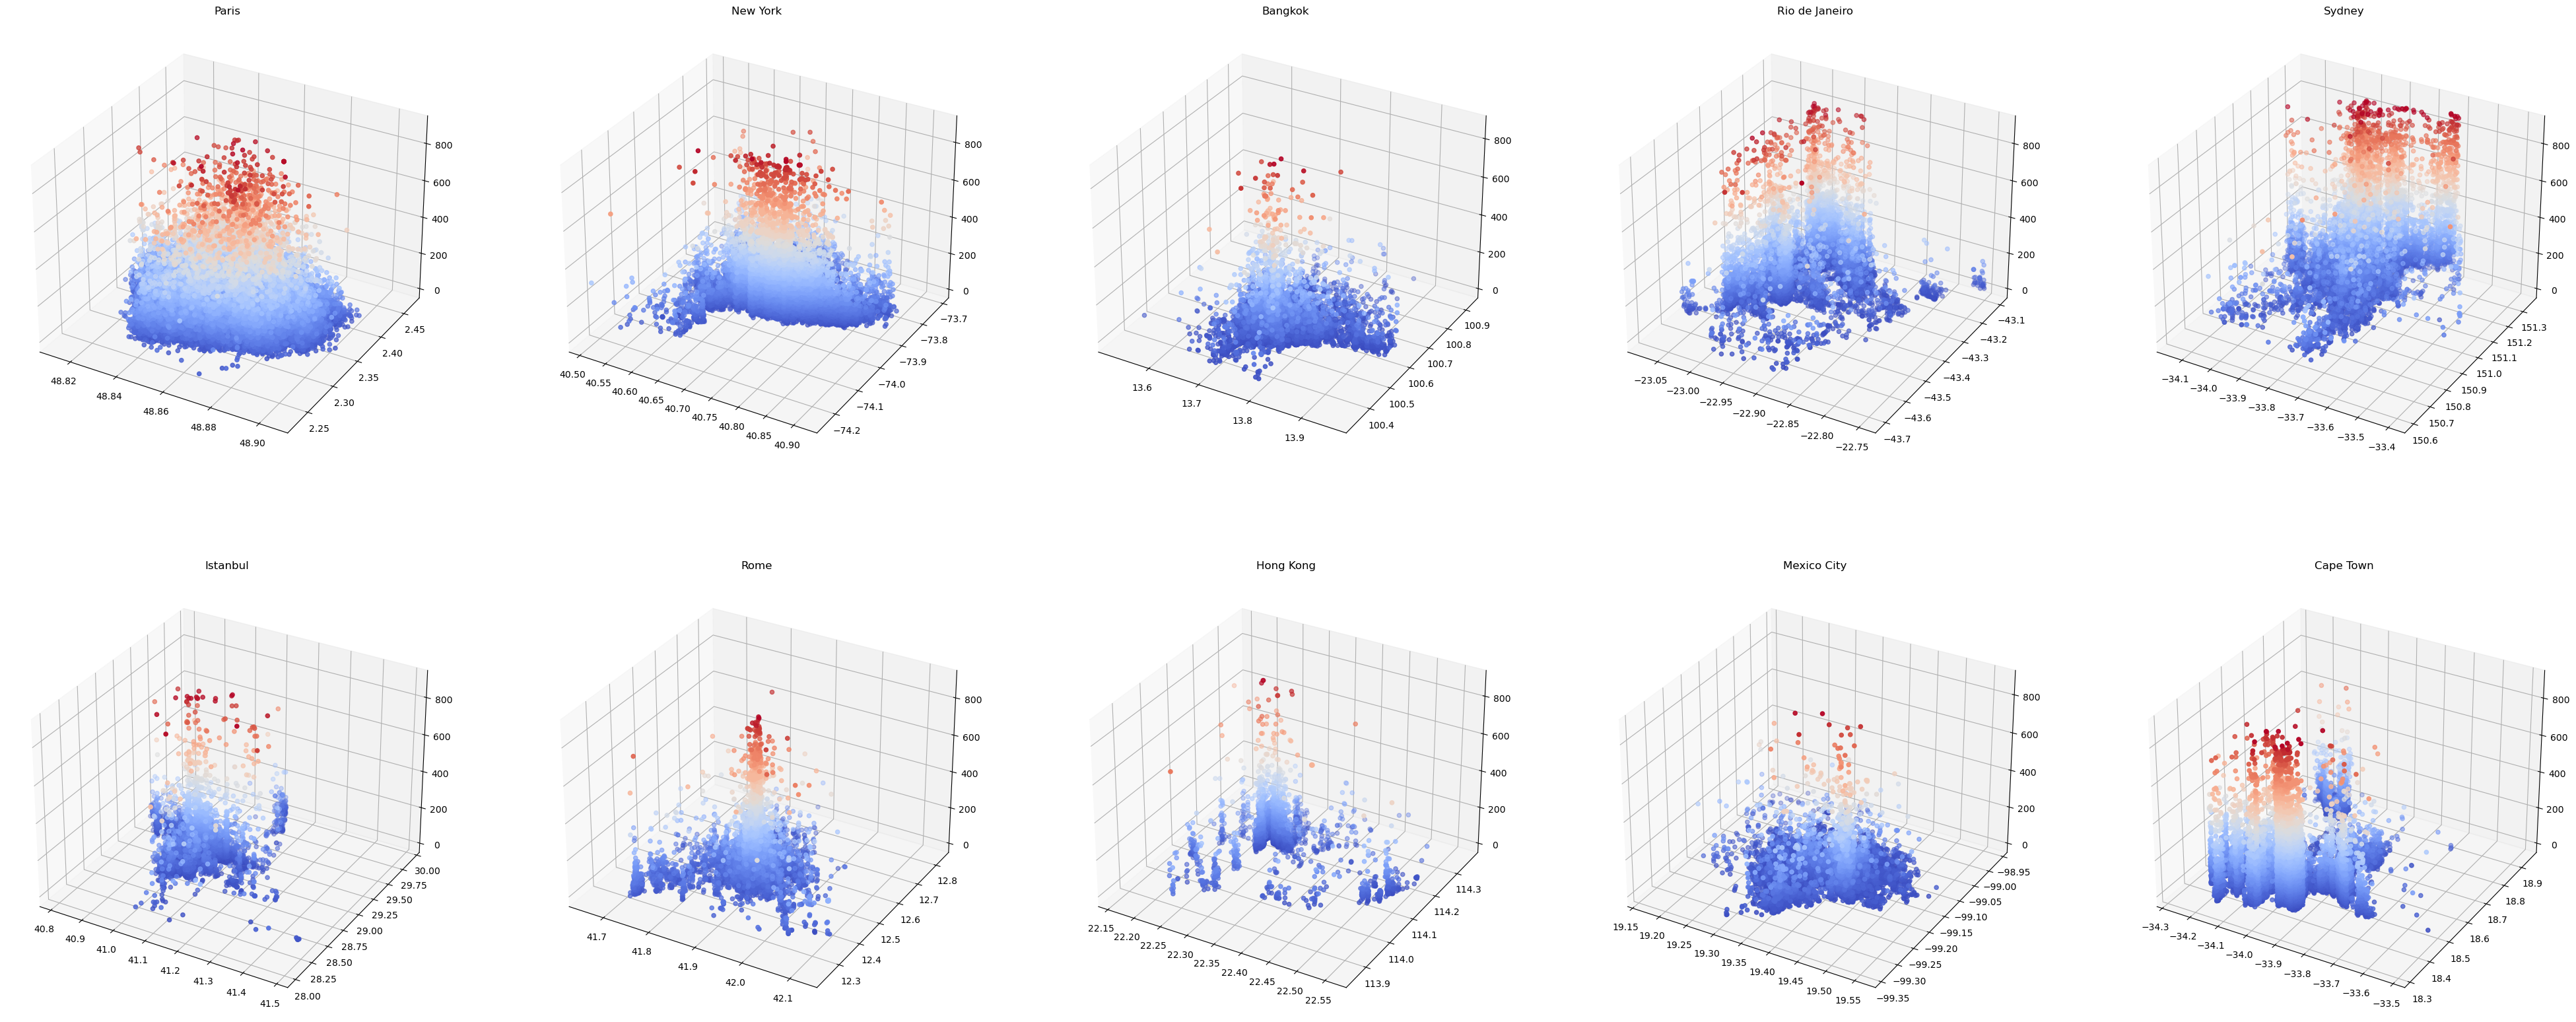

In [36]:
citylist = [city0,city1,city2,city3,city4,
            city5,city6,city7,city8,city9]

fig = plt.figure(figsize=(50,20))
for i in range(2):
    for j in range(5):
        num = i*5+j
        city_draw = citylist[num]
        ax = fig.add_subplot(2,5,num+1,projection='3d')
        ax.scatter(city_draw['latitude'],city_draw['longitude'],city_draw['price(dollar)'],c=city_draw['price(dollar)'],cmap='coolwarm')
        ax.set_title(city[num])

plt.show()

#### （3）'amenities'特征展开

In [37]:
#amenity特征处理，将 'amenities' 列中的字符串形式的列表转换为Python列表
amenity = data['amenities']
amenity = amenity.apply(eval)

#展平嵌套列表并输出频率最高的前5个元素
def flatten(series):
    return pd.Series([x for _list in series for x in _list])

amenity_count = flatten(amenity).value_counts()
print(amenity_count[:5])

Wifi                       254971
Essentials                 248786
Long term stays allowed    236262
Kitchen                    236241
TV                         209111
Name: count, dtype: int64


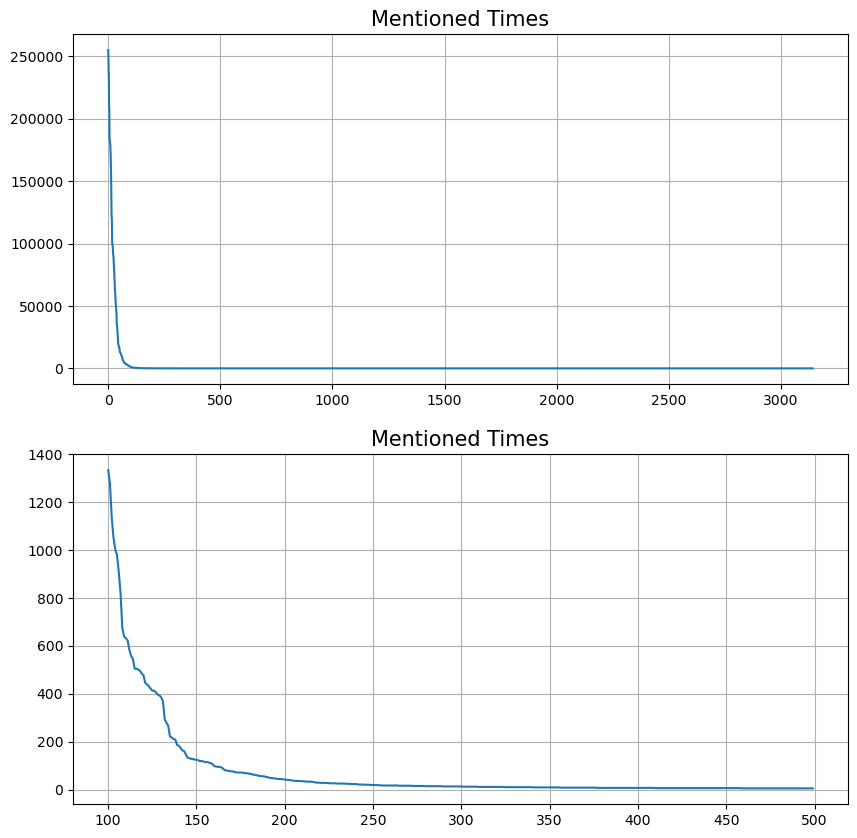

In [38]:
#可视化amenity中每一个tag被提及的次数
fig,ax = plt.subplots(2,1,figsize = (10,10))
ax[0].plot(amenity_count.values)
ax[0].set_title('Mentioned Times',fontsize=15)
ax[0].grid()

x = [i for i in range(100,500)]
ax[1].plot(x,amenity_count.values[100:500])
ax[1].set_title('Mentioned Times',fontsize=15)
ax[1].grid()
plt.show()

In [39]:
%%time
def boolean(df, unique_items):
    # Create empty dict
    bool_dict = {}

    # Loop through all the tags
    for i, item in enumerate(unique_items):
        # Apply boolean mask
        bool_dict[item] = df.apply(lambda x: item in x)

    # Return the results as a dataframe
    return pd.DataFrame(bool_dict)

#将 'amenities' 列中被提及次数超过总样本数1%的项目转换为布尔值
amenity_top = amenity_count[amenity_count>=(0.01*len(data))]
amenity_bool = boolean(amenity,amenity_top.keys())
amenity_int = amenity_bool.astype(int)

print("The shape of matrix is:",amenity_int.shape)

The shape of matrix is: (274034, 87)
CPU times: total: 4.27 s
Wall time: 16.6 s


In [40]:
#将展开后的特征重新加回特征集中
data = data.join(amenity_int)
data = data.drop(columns='amenities')

#### （四）高斯聚类

In [69]:
#为了避免数据泄露，在这里划分数据集进行特征构造
X = data.drop('price(dollar)',axis=1)
Y = data['price(dollar)']
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.2,random_state=seed)

In [78]:
#根据数据特性，将需要聚类的数据划分为三类
host = ['host_duration','host_location','host_response_time','host_response_rate',
        'host_acceptance_rate','host_is_superhost','host_total_listings_count',
        'host_has_profile_pic','host_identity_verified']
host_train = X_train[host]
host_test = X_test[host]

apartment = ['property_type','room_type','accommodates','bedrooms',
           'minimum_nights','maximum_nights']
apartment_train = X_train[apartment]
apartment_test = X_test[apartment]

review = ['review_scores_rating','review_scores_accuracy','review_scores_cleanliness',
          'review_scores_checkin','review_scores_communication','review_scores_location','review_scores_value']
review_train = X_train[review]
review_test = X_test[review]

##### (1)"host"类特征

In [47]:
%%time
n_comp = np.arange(1,11)

models1 = [GMM(n,covariance_type='full',random_state=seed).fit(host_train)
          for n in n_comp]

CPU times: total: 3min 35s
Wall time: 4min 7s


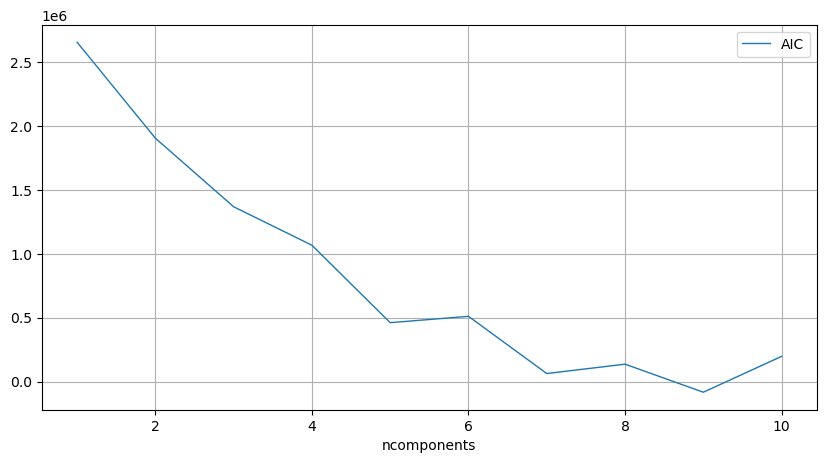

In [79]:
fig,ax = plt.subplots(figsize=(10,5))
ax.plot(n_comp, [m.aic(host_test) for m in models1],label='AIC',lw=1)
ax.legend(loc='best')
ax.grid()
ax.set_xlabel('n components')
plt.show()

In [49]:
%%time
gmm1 = GMM(n_components=9).fit(host_train)

CPU times: total: 27 s
Wall time: 31.9 s


In [70]:
host_feat_train = pd.DataFrame(gmm1.predict_proba(host_train),
                               index=X_train.index,
                               columns=['host' + str(i) for i in range(9)])
X_train = X_train.join(host_feat_train)

host_feat_test = pd.DataFrame(gmm1.predict_proba(host_test),
                              index=X_test.index,
                              columns=['host' + str(i) for i in range(9)])
X_test = X_test.join(host_feat_test)

##### (2)"apartment"类特征

In [84]:
%%time
n_comp = np.arange(1,21)

models2 = [GMM(n,covariance_type='full',random_state=seed).fit(apartment_train)
          for n in n_comp]

CPU times: total: 3min 58s
Wall time: 8min 55s


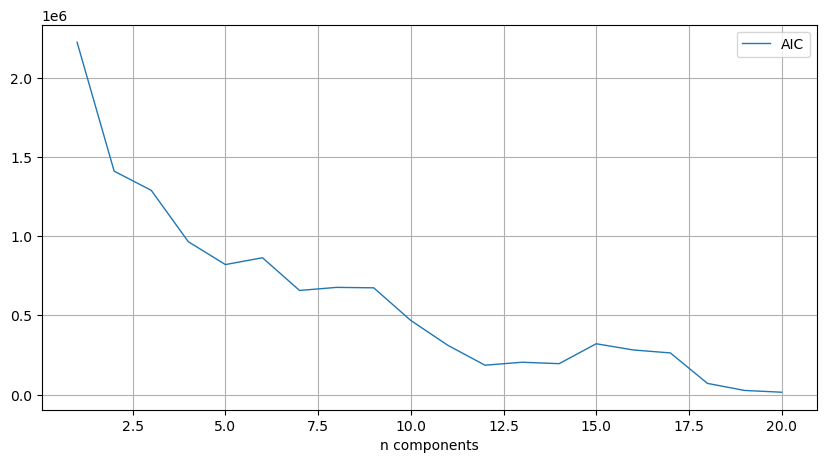

In [85]:
fig,ax = plt.subplots(figsize=(10,5))
ax.plot(n_comp, [m.aic(apartment_test) for m in models2],label='AIC',lw=1)
ax.legend(loc='best')
ax.grid()
ax.set_xlabel('n components')
plt.show()

In [86]:
%%time
gmm2 = GMM(n_components=18).fit(apartment_train)

CPU times: total: 33.5 s
Wall time: 1min 12s


In [91]:
apartment_feat_train = pd.DataFrame(gmm2.predict_proba(apartment_train),
                                    index=X_train.index,
                                    columns=['apartment' + str(i) for i in range(18)])
X_train = X_train.join(apartment_feat_train)

apartment_feat_test = pd.DataFrame(gmm2.predict_proba(apartment_test),
                                   index=X_test.index,
                                   columns=['apartment' + str(i) for i in range(18)])
X_test = X_test.join(apartment_feat_test)

##### (3)"review"类特征

In [92]:
%%time
n_comp = np.arange(1,11)

models3 = [GMM(n,covariance_type='full',random_state=seed).fit(review_train)
          for n in n_comp]

CPU times: total: 1min 21s
Wall time: 2min 7s


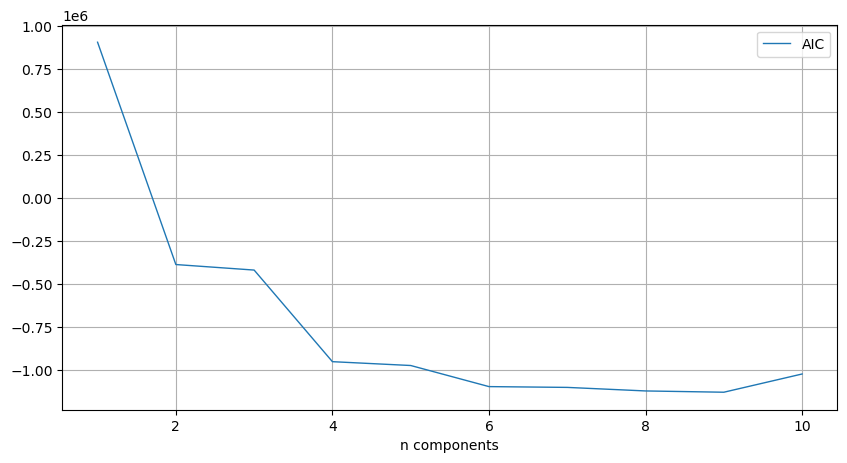

In [93]:
fig,ax = plt.subplots(figsize=(10,5))
ax.plot(n_comp, [m.aic(review_test) for m in models3],label='AIC',lw=1)
ax.legend(loc='best')
ax.grid()
ax.set_xlabel('n components')
plt.show()

In [94]:
%%time
gmm3 = GMM(n_components=6).fit(review_train)

CPU times: total: 4.33 s
Wall time: 9.53 s


In [101]:
review_feat_train = pd.DataFrame(gmm3.predict_proba(review_train),
                                 index=X_train.index,
                                 columns=['review' + str(i) for i in range(6)])
X_train = X_train.join(review_feat_train)

review_feat_test = pd.DataFrame(gmm3.predict_proba(review_test),
                                index=X_test.index,
                                columns=['review' + str(i) for i in range(6)])
X_test = X_test.join(review_feat_test)

## <font color='red'>临时存档点，最后需要删除

In [102]:
X_train.to_csv('.\\tmp\\X_train_gauss.csv')
X_test.to_csv('.\\tmp\\X_test_gauss.csv')
Y_train.to_csv('.\\tmp\\Y_train_gauss.csv')
Y_test.to_csv('.\\tmp\\Y_test_gauss.csv')

#### （三）特征筛选

In [2]:
X_train = pd.read_csv('.\\tmp\\X_train_gauss.csv',index_col=0)
X_test = pd.read_csv('.\\tmp\\X_test_gauss.csv',index_col=0)
Y_train = pd.read_csv('.\\tmp\\Y_train_gauss.csv',index_col=0)
Y_test = pd.read_csv('.\\tmp\\Y_test_gauss.csv',index_col=0)

In [3]:
#初步删除难以使用的特征
drop_col = ['listing_id','name','host_id','host_since',
            'within a day','within a few hours','within an hour','city',
            'instant_bookable','instant_bookable_f','room_type']

X_train.drop(drop_col,axis=1,inplace=True)
X_test.drop(drop_col,axis=1,inplace=True)

In [4]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 219227 entries, 94930 to 129900
Columns: 158 entries, host_duration to review5
dtypes: bool(16), float64(47), int64(95)
memory usage: 242.5 MB


目前数据集中共有158个数值特征，为了减少之后的时间复杂度并加强模型的泛化能力，我们首先使用能够适应高维数据的随机森林对特征进行一遍筛选。

In [8]:
%%time
#训练模型进行筛选
forest = RandomForestRegressor(n_estimators=500, max_leaf_nodes=64,n_jobs=-1,random_state=seed)
forest.fit(X_train,np.array(Y_train).reshape(-1))

CPU times: total: 1h 13min 9s
Wall time: 9min 45s


RandomForestRegressor(max_leaf_nodes=64, n_estimators=500, n_jobs=-1,
                      random_state=111)

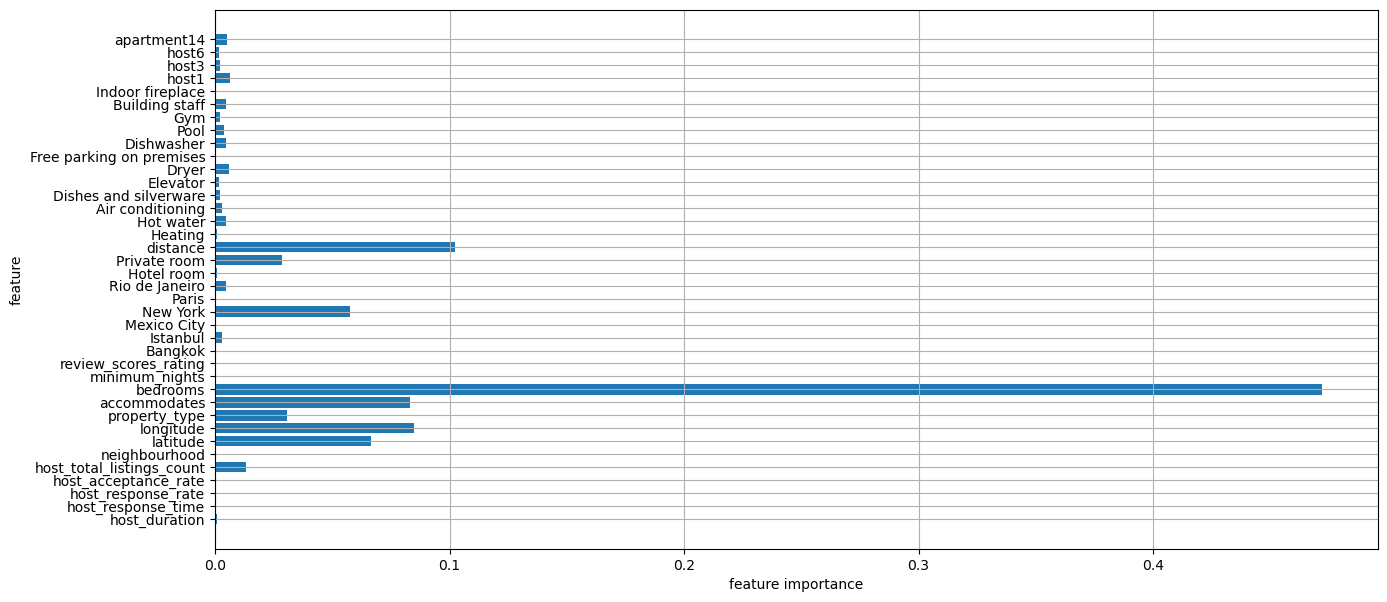

In [9]:
#计算特征重要性并进行可视化
feat_import_value = forest.feature_importances_
feat_name = X_train.columns

#选择重要的特征
thresh = 0.0001
feat_name_chose = feat_name[feat_import_value >= thresh]
feat_value_chose = feat_import_value[feat_import_value >= thresh]

#进行可视化
fig,ax = plt.subplots(figsize=(15,7))
ax.barh(feat_name_chose,feat_value_chose)
ax.set_xlabel('feature importance')
ax.set_ylabel('feature')
ax.grid()
plt.show()

In [10]:
%%time
shuff = permutation_importance(forest,X_test,Y_test,n_repeats=10,n_jobs=-1,random_state=seed)
feat_import_value_shuff = shuff.importances_mean

CPU times: total: 37.8 s
Wall time: 14min 14s


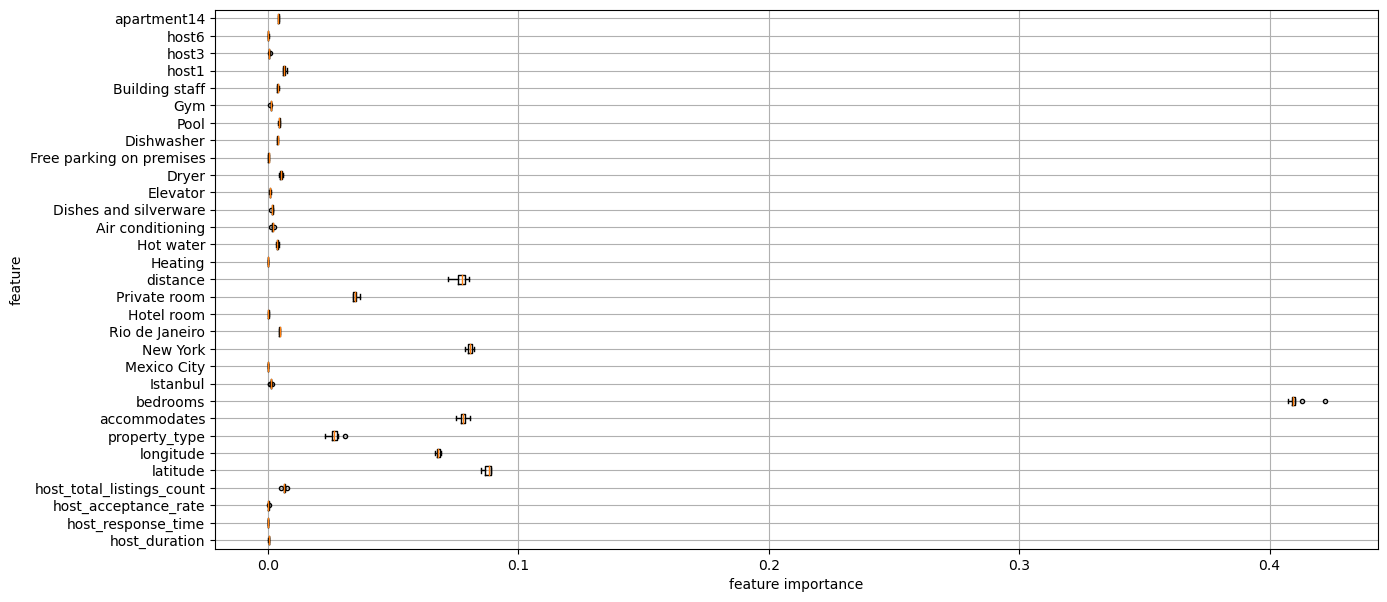

In [13]:
#筛选出特征值大于0.1%的特征
feat_name_shuff_chose = feat_name[feat_import_value_shuff >= thresh]
feat_value_shuff_chose = shuff.importances[feat_import_value_shuff >= thresh].T

#进行可视化
fig,ax = plt.subplots(figsize=(15,7))
plt.rcParams['boxplot.flierprops.markersize'] = 3

ax.boxplot(feat_value_shuff_chose,vert=False)
ax.set_yticklabels(feat_name_shuff_chose)
ax.set_xlabel('feature importance')
ax.set_ylabel('feature')
ax.grid()
plt.show()

In [139]:
X_train = X_train[feat_name_shuff_chose]
X_test = X_test[feat_name_shuff_chose]

## <font color='red'>临时存档点，最后需要删除

In [150]:
X_train.to_csv('.\\tmp\\X_train.csv')
X_test.to_csv('.\\tmp\\X_test.csv')
Y_train.to_csv('.\\tmp\\Y_train.csv')
Y_test.to_csv('.\\tmp\\Y_test.csv')

## 模型训练
### 模型一：Xgboost
#### Version 1.0：直接进行训练

In [4]:
X_train = pd.read_csv('.\\tmp\\X_train.csv',index_col=0)
X_test = pd.read_csv('.\\tmp\\X_test.csv',index_col=0)
Y_train = pd.read_csv('.\\tmp\\Y_train.csv',index_col=0)
Y_test = pd.read_csv('.\\tmp\\Y_test.csv',index_col=0)

In [7]:
%%time
model1 = xgb.XGBRegressor(random_state=seed)
model1.fit(X_train,Y_train)
Y_pred1 = model1.predict(X_test)

CPU times: total: 10.1 s
Wall time: 2.34 s


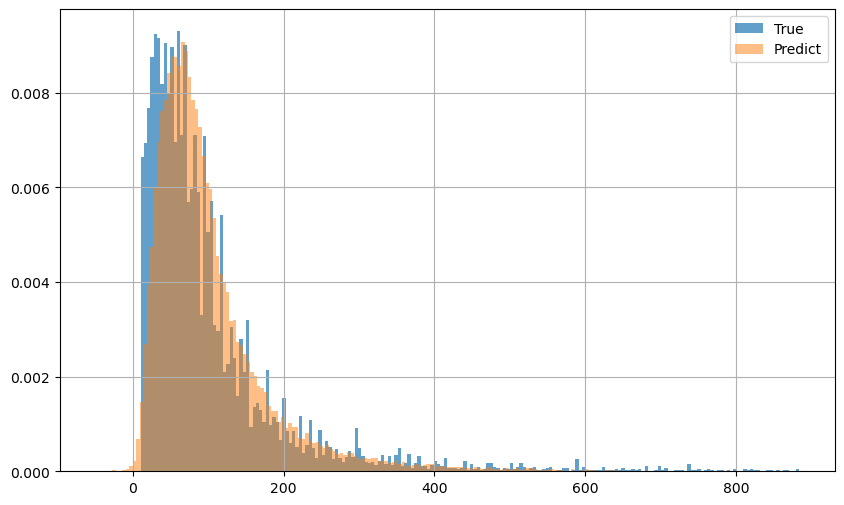

In [8]:
#绘制分布图
fig,ax = plt.subplots(figsize=(10,6))

ax.hist(Y_test,bins=200,density=True,label='True',alpha=0.7)
ax.hist(Y_pred1,bins=200,density=True,label='Predict',alpha=0.5)

ax.legend(loc='upper right')
ax.grid()

plt.show()

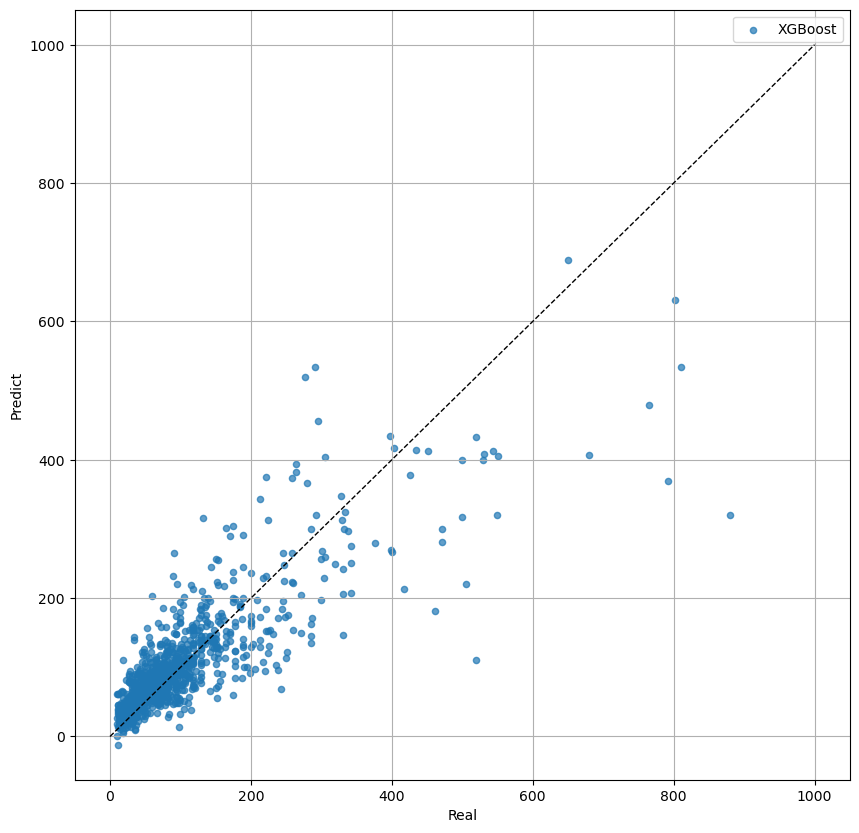

In [9]:
# 绘制预测值和实际值的图
fig,ax = plt.subplots(figsize=(10,10))

ax.scatter(Y_test[0:1000], Y_pred1[0:1000], label='XGBoost', s=20, alpha=0.7)
ax.plot((0,1000),(0,1000), '--k', lw=1)

ax.set_xlabel('Real')
ax.set_ylabel('Predict')
ax.legend(loc='upper right')
ax.grid()

plt.show()

In [10]:
mean_squared_error(Y_test,Y_pred1,squared=False)

66.8947513670952

#### Version 2.0：对目标变量进行对数化处理
Version 1.0的版本里面会出现负的预测值，这在现实中是不可接受的，因此我们使用对数化操作对数据进行处理。

In [11]:
#对目标变量进行对数化
Y_train_log = np.log(Y_train)
Y_test_log = np.log(Y_test)

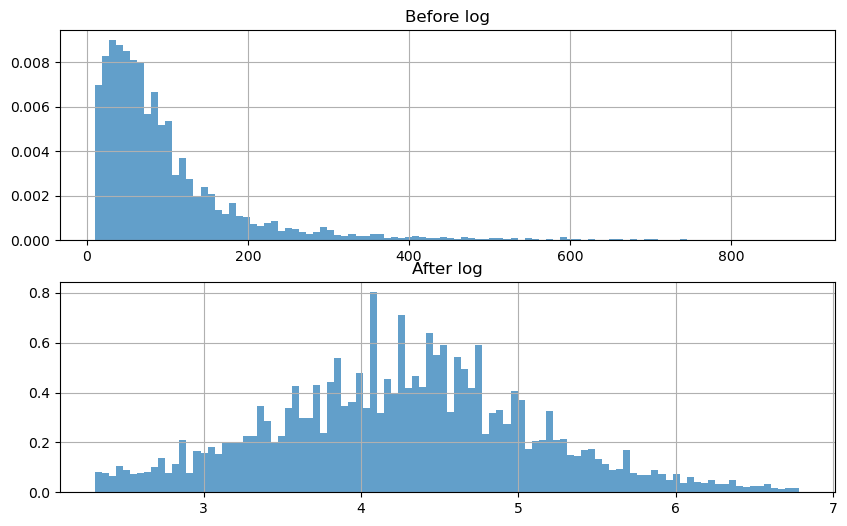

In [12]:
#绘制分布图
fig,ax = plt.subplots(2,1,figsize=(10,6))

ax[0].hist(Y_train,bins=100,density=True,label='True',alpha=0.7)
ax[1].hist(Y_train_log,bins=100,density=True,label='Predict',alpha=0.7)

ax[0].set_title('Before log')
ax[1].set_title('After log')

ax[0].grid()
ax[1].grid()

plt.show()

In [13]:
%%time
model2 = xgb.XGBRegressor(random_state=seed)
model2.fit(X_train,Y_train_log)
Y_pred_log2 = model2.predict(X_test)
Y_pred2 = np.exp(Y_pred_log2)

CPU times: total: 11.2 s
Wall time: 2.49 s


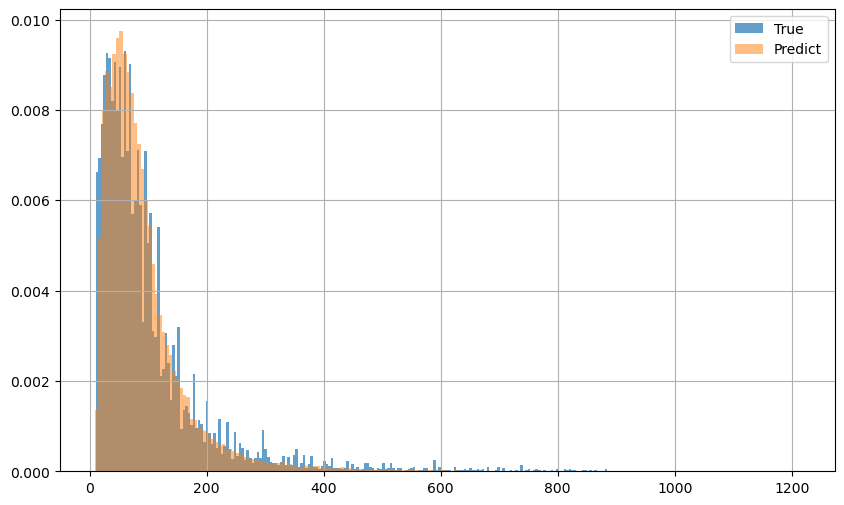

In [14]:
#绘制分布图
fig,ax = plt.subplots(figsize=(10,6))

ax.hist(Y_test,bins=200,density=True,label='True',alpha=0.7)
ax.hist(Y_pred2,bins=200,density=True,label='Predict',alpha=0.5)

ax.legend(loc='upper right')
ax.grid()

plt.show()

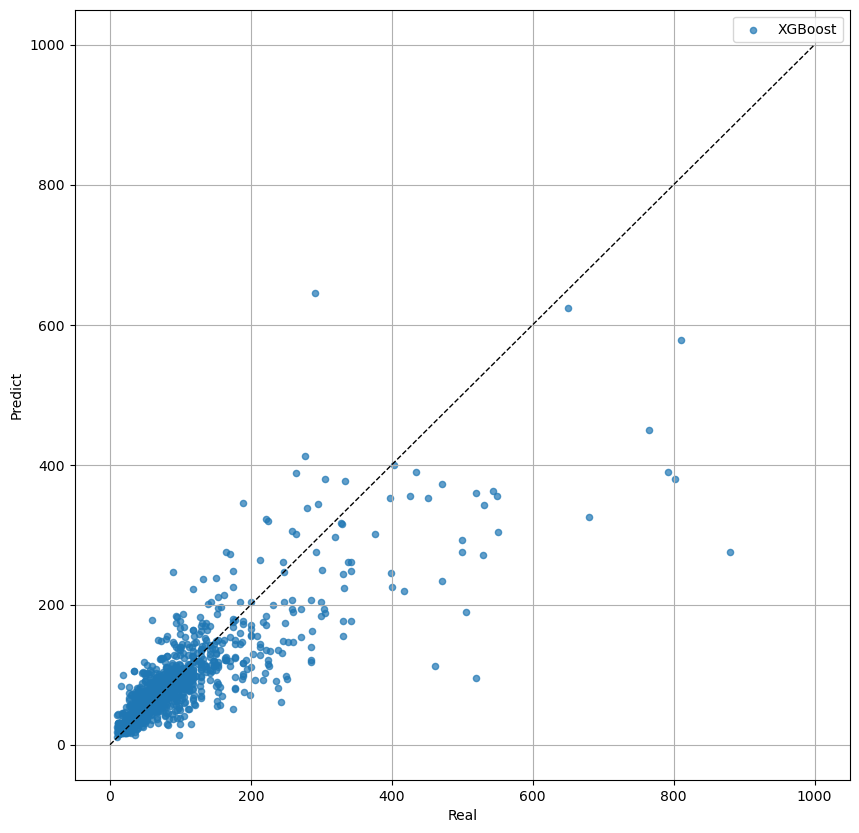

In [15]:
# 绘制预测值和实际值的图
fig,ax = plt.subplots(figsize=(10,10))

ax.scatter(Y_test[0:1000], Y_pred2[0:1000], label='XGBoost', s=20, alpha=0.7)
ax.plot((0,1000),(0,1000), '--k', lw=1)

ax.set_xlabel('Real')
ax.set_ylabel('Predict')
ax.legend(loc='upper right')
ax.grid()

plt.show()

In [16]:
mean_squared_error(Y_test,Y_pred2,squared=False)

68.98384116085104

## Version 3.0:使用Optuna进行调参

In [17]:
def objective(trial):
    params = {'eta':trial.suggest_float('eta',0.0,1.0),
              'subsample':trial.suggest_float('subsample',0.0,1.0,step=0.1),
              'colsample_bytree':trial.suggest_float('colsample_bytree', 0.0, 1.0,step=0.1),
              'max_depth': trial.suggest_int('max_depth',3,20),
              'alpha':trial.suggest_float('alpha', 1e-3,1e3,log=True),
              'lambda':trial.suggest_float('lambda',1e-3,1e3,log=True),
              'gamma':trial.suggest_float('gamma',1e-3,1e3,log=True),
              'min_child_weight':trial.suggest_int('min_child_weight', 1,100),
              'random_state':seed}
    model3 = xgb.XGBRegressor(**params)
    model3.fit(X_train,Y_train_log)
    Y_pred_log3 = model3.predict(X_test)
    Y_pred3 = np.exp(Y_pred_log3)
    rmse = mean_squared_error(Y_test,Y_pred3, squared=False)
    return rmse

In [18]:
n_trials = 200

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=n_trials)

print('Number of finished trials:', len(study.trials))
print("------------------------------------------------")
print('Best trial:', study.best_trial.params)
print("------------------------------------------------")
print(study.trials_dataframe())
print("------------------------------------------------")

[I 2023-12-25 11:20:55,107] A new study created in memory with name: no-name-41bd6347-842f-44f1-9c93-54ccd8e9a3c4
[I 2023-12-25 11:20:58,117] Trial 0 finished with value: 79.28781581410912 and parameters: {'eta': 0.06468019437800243, 'subsample': 1.0, 'colsample_bytree': 0.4, 'max_depth': 17, 'alpha': 538.429192714475, 'lambda': 0.013131949176885666, 'gamma': 0.010223427804730187, 'min_child_weight': 61}. Best is trial 0 with value: 79.28781581410912.
[I 2023-12-25 11:21:00,318] Trial 1 finished with value: 76.6300478650889 and parameters: {'eta': 0.9905251552234741, 'subsample': 0.2, 'colsample_bytree': 0.0, 'max_depth': 11, 'alpha': 0.4708209123275019, 'lambda': 7.345252121452132, 'gamma': 0.8773584716506195, 'min_child_weight': 68}. Best is trial 1 with value: 76.6300478650889.
[I 2023-12-25 11:21:04,695] Trial 2 finished with value: 71.41358186637213 and parameters: {'eta': 0.11452996995051834, 'subsample': 1.0, 'colsample_bytree': 0.30000000000000004, 'max_depth': 13, 'alpha': 0.0

Number of finished trials: 200
------------------------------------------------
Best trial: {'eta': 0.19746206571899852, 'subsample': 0.9, 'colsample_bytree': 0.8, 'max_depth': 16, 'alpha': 2.245467538172984, 'lambda': 1.273307804855162, 'gamma': 0.004620564984733545, 'min_child_weight': 18}
------------------------------------------------
     number      value             datetime_start          datetime_complete  \
0         0  79.287816 2023-12-25 11:20:55.109731 2023-12-25 11:20:58.116050   
1         1  76.630048 2023-12-25 11:20:58.120049 2023-12-25 11:21:00.317776   
2         2  71.413582 2023-12-25 11:21:00.320775 2023-12-25 11:21:04.694105   
3         3  67.503246 2023-12-25 11:21:04.697108 2023-12-25 11:21:08.863081   
4         4  68.400812 2023-12-25 11:21:08.865081 2023-12-25 11:21:12.324791   
..      ...        ...                        ...                        ...   
195     195  73.312893 2023-12-25 11:47:57.801963 2023-12-25 11:48:01.530527   
196     196  66.24

In [19]:
%%time
xgb_parama = study.best_trial.params
XGB = xgb.XGBRegressor(**xgb_parama,random_state=seed)

XGB.fit(X_train,Y_train_log)
Y_pred_log3 = XGB.predict(X_test)
Y_pred3 = np.exp(Y_pred_log3)

CPU times: total: 53.6 s
Wall time: 10.2 s


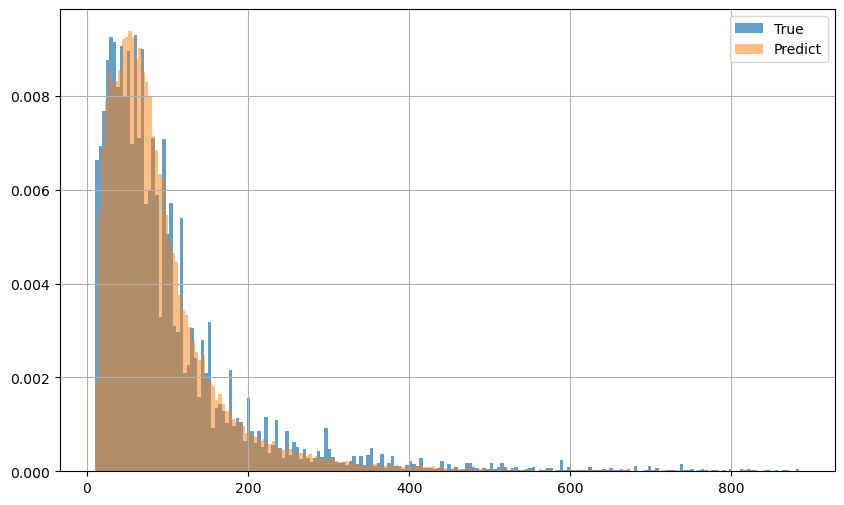

In [20]:
#绘制分布图
fig,ax = plt.subplots(figsize=(10,6))

ax.hist(Y_test,bins=200,density=True,label='True',alpha=0.7)
ax.hist(Y_pred3,bins=200,density=True,label='Predict',alpha=0.5)

ax.legend(loc='upper right')
ax.grid()

plt.show()

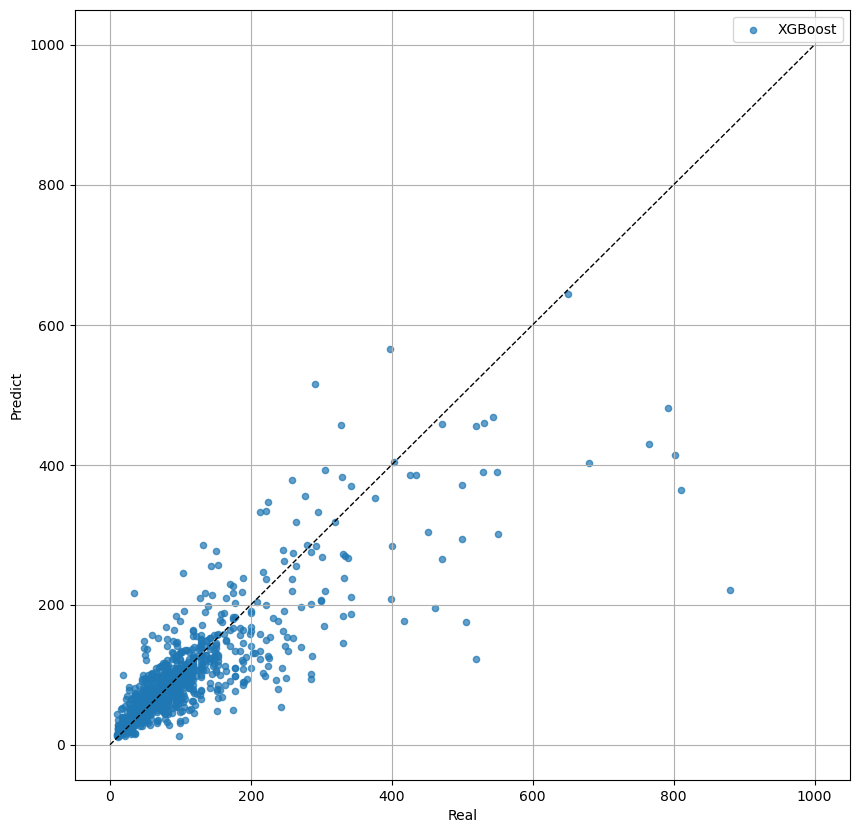

In [21]:
# 绘制预测值和实际值的图
fig,ax = plt.subplots(figsize=(10,10))

ax.scatter(Y_test[0:1000], Y_pred3[0:1000], label='XGBoost', s=20, alpha=0.7)
ax.plot((0,1000),(0,1000), '--k', lw=1)

ax.set_xlabel('Real')
ax.set_ylabel('Predict')
ax.legend(loc='upper right')
ax.grid()

plt.show()

In [22]:
mean_squared_error(Y_test,Y_pred3,squared=False)

65.80323430694047

### 模型二：Adaboost

In [46]:
def objective1(trial):
    params = {'n_estimators':trial.suggest_int('n_estimators',50,500,step=50),
              'learning_rate':trial.suggest_float('learning_rate',0.05,1.0,step=0.05),
              'random_state':seed}
    Ada = AdaBoostRegressor(DecisionTreeRegressor(max_depth=3),**params)
    Ada.fit(X_train,np.array(Y_train_log).reshape(-1))
    Y_pred_log4 = Ada.predict(X_test)
    Y_pred4 = np.exp(Y_pred_log4)
    rmse = mean_squared_error(Y_test,Y_pred4, squared=False)
    return rmse

In [48]:
n_trials = 50

study1 = optuna.create_study(direction='minimize')
study1.optimize(objective1, n_trials=n_trials)

print('Number of finished trials:', len(study1.trials))
print("------------------------------------------------")
print('Best trial:', study1.best_trial.params)
print("------------------------------------------------")
print(study1.trials_dataframe())
print("------------------------------------------------")

[I 2023-12-25 13:22:04,617] A new study created in memory with name: no-name-a5f0477e-83c9-4466-856d-bf8d942c1986
[I 2023-12-25 13:23:04,333] Trial 0 finished with value: 88.3011945889575 and parameters: {'n_estimators': 100, 'learning_rate': 0.7500000000000001}. Best is trial 0 with value: 88.3011945889575.
[I 2023-12-25 13:23:46,268] Trial 1 finished with value: 88.30221325873578 and parameters: {'n_estimators': 250, 'learning_rate': 0.9000000000000001}. Best is trial 0 with value: 88.3011945889575.
[I 2023-12-25 13:24:21,937] Trial 2 finished with value: 88.65674250009086 and parameters: {'n_estimators': 150, 'learning_rate': 0.8}. Best is trial 0 with value: 88.3011945889575.
[I 2023-12-25 13:24:55,250] Trial 3 finished with value: 89.11601524599513 and parameters: {'n_estimators': 50, 'learning_rate': 1.0}. Best is trial 0 with value: 88.3011945889575.
[I 2023-12-25 13:26:00,265] Trial 4 finished with value: 88.42743547193578 and parameters: {'n_estimators': 50, 'learning_rate': 0

Number of finished trials: 50
------------------------------------------------
Best trial: {'n_estimators': 350, 'learning_rate': 0.4}
------------------------------------------------
    number      value             datetime_start          datetime_complete  \
0        0  88.301195 2023-12-25 13:22:04.619761 2023-12-25 13:23:04.333534   
1        1  88.302213 2023-12-25 13:23:04.333534 2023-12-25 13:23:46.268541   
2        2  88.656743 2023-12-25 13:23:46.268541 2023-12-25 13:24:21.936384   
3        3  89.116015 2023-12-25 13:24:21.938412 2023-12-25 13:24:55.250112   
4        4  88.427435 2023-12-25 13:24:55.251113 2023-12-25 13:26:00.265161   
5        5  88.326914 2023-12-25 13:26:00.280784 2023-12-25 13:30:36.653810   
6        6  88.463776 2023-12-25 13:30:36.656809 2023-12-25 13:31:45.185149   
7        7  88.399985 2023-12-25 13:31:45.187154 2023-12-25 13:35:05.069679   
8        8  88.399985 2023-12-25 13:35:05.069679 2023-12-25 13:38:07.578362   
9        9  89.116015 2023

In [49]:
%%time
Ada_parama = study1.best_trial.params
Ada = AdaBoostRegressor(DecisionTreeRegressor(max_depth=3),**Ada_parama)
Ada.fit(X_train,np.array(Y_train_log).reshape(-1))
Y_pred_log4 = Ada.predict(X_test)
Y_pred4 = np.exp(Y_pred_log4)
rmse = mean_squared_error(Y_test,Y_pred4, squared=False)

CPU times: total: 1min 10s
Wall time: 1min 31s


In [50]:
Y_pred_log4 = Ada.predict(X_test)
Y_pred4 = np.exp(Y_pred_log4)
rmse1 = mean_squared_error(Y_test,Y_pred4, squared=False)
rmse2 = mean_squared_error(Y_train,np.exp(Ada.predict(X_train)), squared=False)
print(rmse1)
print(rmse2)

88.34819818202396
88.45919886488993


In [51]:
%%time
a = np.sqrt(-cross_val_score(Ada,X_train,np.array(Y_train).reshape(-1),cv = 6, scoring='neg_mean_squared_error'))
print(a)

[100.4625251  101.88623349  99.48740629  95.45638289 101.98274981
 101.28167814]
CPU times: total: 3min
Wall time: 4min 9s


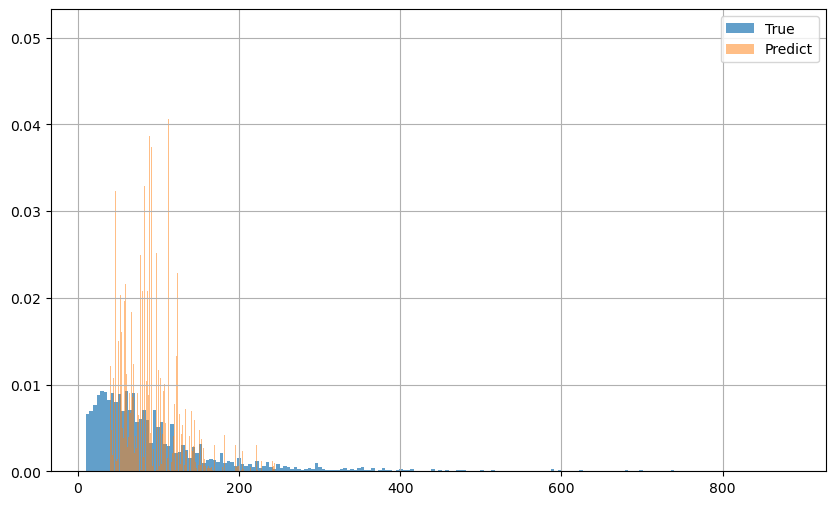

In [52]:
#绘制分布图
fig,ax = plt.subplots(figsize=(10,6))

ax.hist(Y_test,bins=200,density=True,label='True',alpha=0.7)
ax.hist(Y_pred4,bins=200,density=True,label='Predict',alpha=0.5)

ax.legend(loc='upper right')
ax.grid()

plt.show()

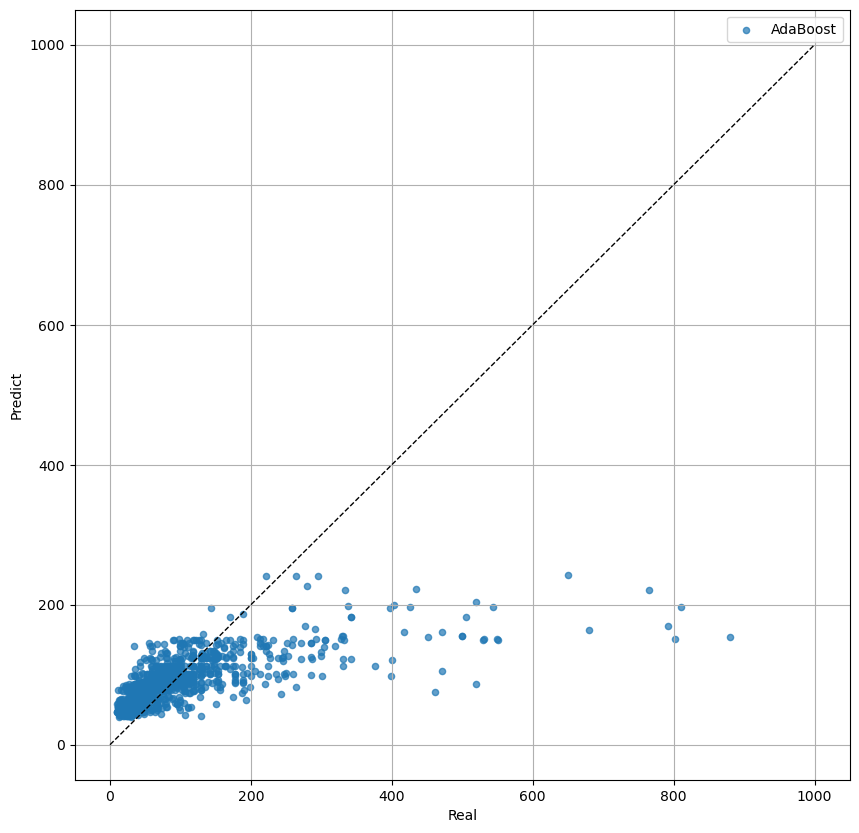

In [53]:
# 绘制预测值和实际值的图
fig,ax = plt.subplots(figsize=(10,10))

ax.scatter(Y_test[0:1000], Y_pred4[0:1000], label='AdaBoost', s=20, alpha=0.7)
ax.plot((0,1000),(0,1000), '--k', lw=1)

ax.set_xlabel('Real')
ax.set_ylabel('Predict')
ax.legend(loc='upper right')
ax.grid()

plt.show()

##### 模型三：Random Forest

In [57]:
def objective2(trial):
    params = {'n_estimators':trial.suggest_int('n_estimators',50,500,step=50),
              'max_depth':trial.suggest_int('max_depth',2,10),
              'random_state':seed,
              'n_jobs':-1}
    forest = RandomForestRegressor(**params)
    forest.fit(X_train,np.array(Y_train_log).reshape(-1))
    Y_pred_log5 = forest.predict(X_test)
    Y_pred5 = np.exp(Y_pred_log5)
    rmse = mean_squared_error(Y_test,Y_pred5, squared=False)
    return rmse

In [59]:
n_trials = 20

study2 = optuna.create_study(direction='minimize')
study2.optimize(objective2, n_trials=n_trials)

print('Number of finished trials:', len(study2.trials))
print("------------------------------------------------")
print('Best trial:', study2.best_trial.params)
print("------------------------------------------------")
print(study2.trials_dataframe())
print("------------------------------------------------")

[I 2023-12-25 15:50:28,941] A new study created in memory with name: no-name-77731c77-d2c4-44a4-b197-362a6cf4952a
[I 2023-12-25 15:51:29,051] Trial 0 finished with value: 95.91546572763416 and parameters: {'n_estimators': 500, 'max_depth': 2}. Best is trial 0 with value: 95.91546572763416.
[I 2023-12-25 15:51:42,160] Trial 1 finished with value: 88.75764197377988 and parameters: {'n_estimators': 50, 'max_depth': 4}. Best is trial 1 with value: 88.75764197377988.
[I 2023-12-25 15:52:18,046] Trial 2 finished with value: 95.88903668099026 and parameters: {'n_estimators': 300, 'max_depth': 2}. Best is trial 1 with value: 88.75764197377988.
[I 2023-12-25 15:56:19,025] Trial 3 finished with value: 76.74914713242424 and parameters: {'n_estimators': 450, 'max_depth': 9}. Best is trial 3 with value: 76.74914713242424.
[I 2023-12-25 15:57:15,760] Trial 4 finished with value: 76.72695366865405 and parameters: {'n_estimators': 100, 'max_depth': 9}. Best is trial 4 with value: 76.72695366865405.
[I

Number of finished trials: 20
------------------------------------------------
Best trial: {'n_estimators': 300, 'max_depth': 10}
------------------------------------------------
    number      value             datetime_start          datetime_complete  \
0        0  95.915466 2023-12-25 15:50:28.944067 2023-12-25 15:51:29.051334   
1        1  88.757642 2023-12-25 15:51:29.067005 2023-12-25 15:51:42.160660   
2        2  95.889037 2023-12-25 15:51:42.160660 2023-12-25 15:52:18.046496   
3        3  76.749147 2023-12-25 15:52:18.046496 2023-12-25 15:56:19.025344   
4        4  76.726954 2023-12-25 15:56:19.025344 2023-12-25 15:57:15.760805   
5        5  82.840081 2023-12-25 15:57:15.760805 2023-12-25 15:59:40.640061   
6        6  92.285970 2023-12-25 15:59:40.655074 2023-12-25 16:01:02.642629   
7        7  76.749177 2023-12-25 16:01:02.642629 2023-12-25 16:02:24.535350   
8        8  76.736070 2023-12-25 16:02:24.537365 2023-12-25 16:04:12.916616   
9        9  85.624823 2023-12-2

In [62]:
%%time
forest_parama = study2.best_trial.params
forest = RandomForestRegressor(**forest_parama,random_state=seed,n_jobs=-1)
forest.fit(X_train,np.array(Y_train_log).reshape(-1))
Y_pred_log5 = forest.predict(X_test)
Y_pred5 = np.exp(Y_pred_log5)
rmse = mean_squared_error(Y_test,Y_pred5, squared=False)
print(rmse)

75.2635045876975
CPU times: total: 23min 3s
Wall time: 2min 59s


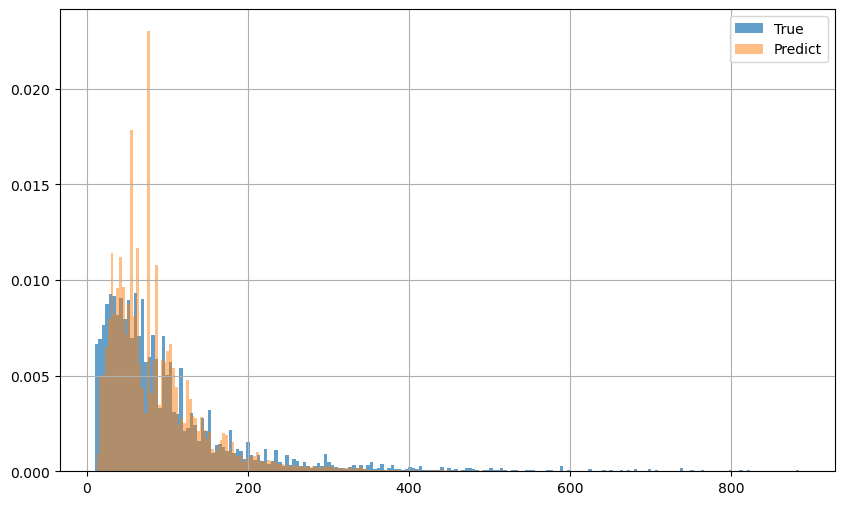

In [63]:
#绘制分布图
fig,ax = plt.subplots(figsize=(10,6))

ax.hist(Y_test,bins=200,density=True,label='True',alpha=0.7)
ax.hist(Y_pred5,bins=200,density=True,label='Predict',alpha=0.5)

ax.legend(loc='upper right')
ax.grid()

plt.show()

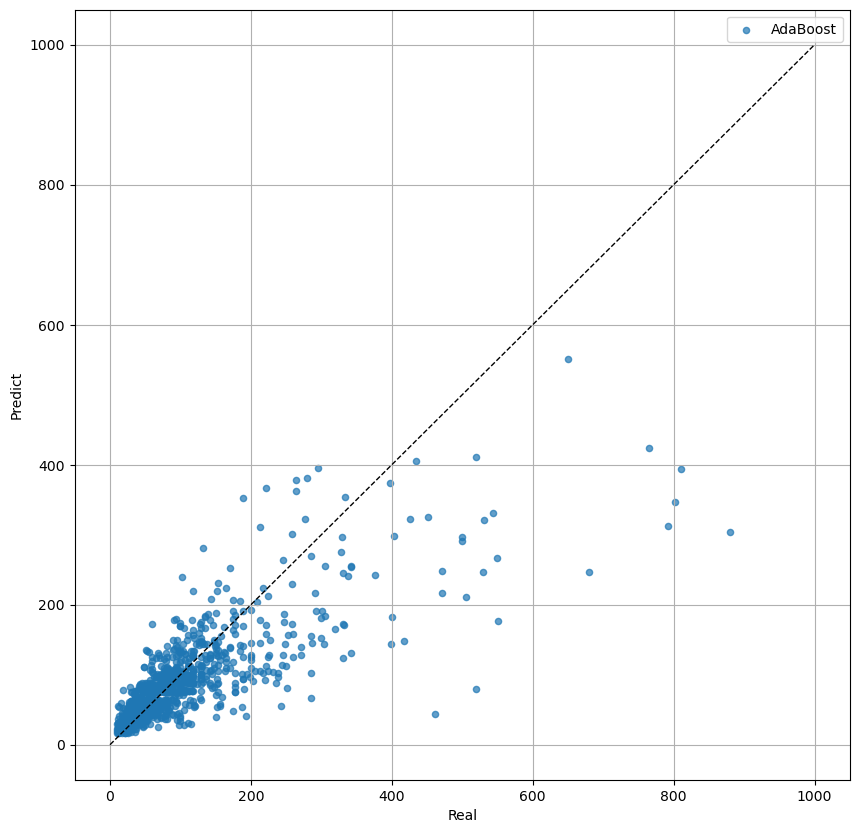

In [64]:
# 绘制预测值和实际值的图
fig,ax = plt.subplots(figsize=(10,10))

ax.scatter(Y_test[0:1000], Y_pred5[0:1000], label='AdaBoost', s=20, alpha=0.7)
ax.plot((0,1000),(0,1000), '--k', lw=1)

ax.set_xlabel('Real')
ax.set_ylabel('Predict')
ax.legend(loc='upper right')
ax.grid()

plt.show()

##### 模型合并：Stacking

In [ ]:
citylist = [city0,city1,city2,city3,city4,
            city5,city6,city7,city8,city9]

fig = plt.figure(figsize=(50,20))
for i in range(2):
    for j in range(5):
        num = i*5+j
        city_draw = citylist[num]
        ax = fig.add_subplot(2,5,num+1,projection='3d')
        ax.scatter(city_draw['latitude'],city_draw['longitude'],city_draw['price(dollar)'],c=city_draw['price(dollar)'],cmap='coolwarm')
        ax.set_title(city[num])

plt.show()

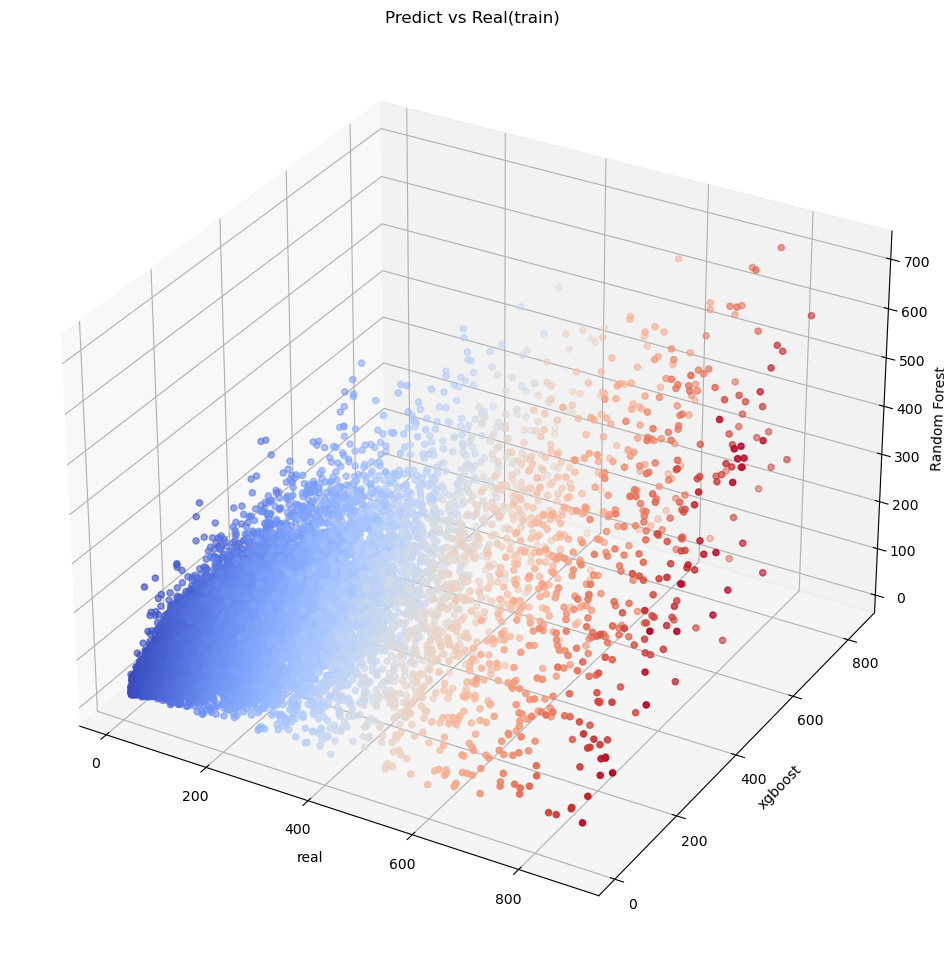

In [83]:
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111,projection='3d')
ax.scatter(Y_test,Y_pred3,Y_pred5,c=Y_test,cmap='coolwarm')
ax.set_xlabel('real')
ax.set_ylabel('xgboost')
ax.set_zlabel('Random Forest')
ax.set_title('Predict vs Real(train)')
plt.show()

In [ ]:
Y_train_xgb = np.exp(XGB.predict(X_train))
Y_train_rf = np.exp(forest.predict(X_train))


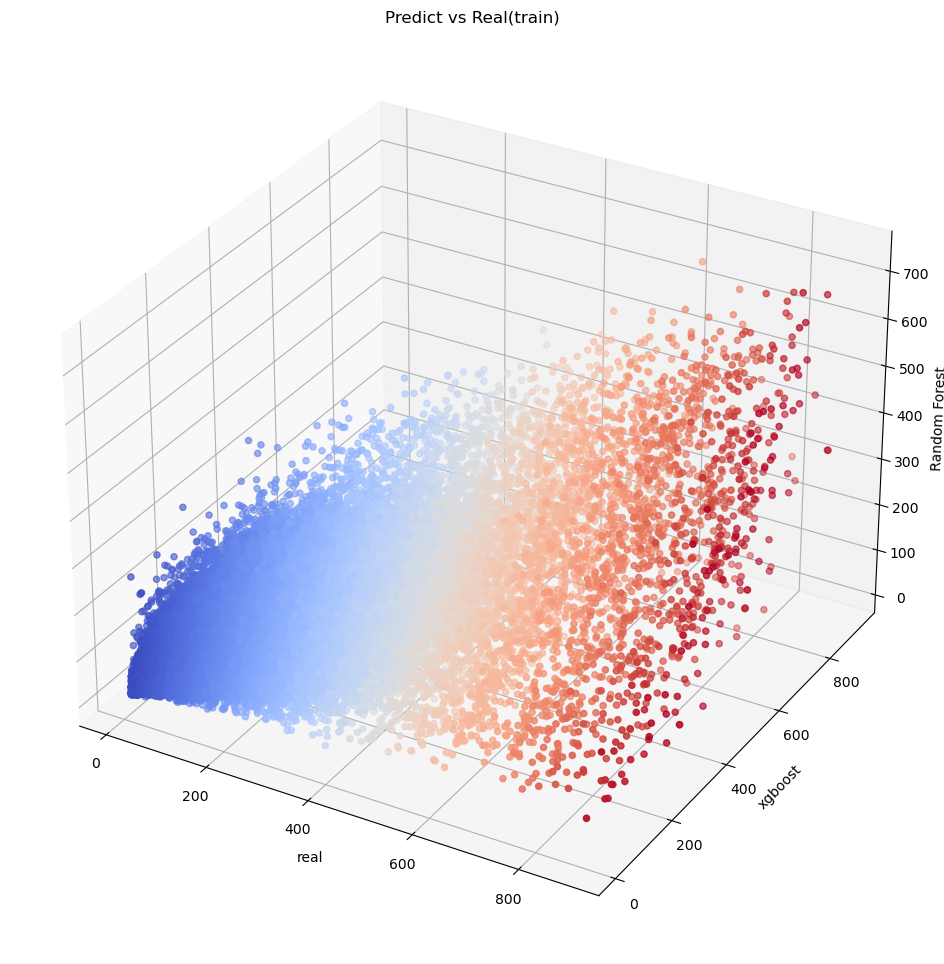

In [84]:
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111,projection='3d')
ax.scatter(Y_train,Y_train_xgb,Y_train_rf,c=Y_train,cmap='coolwarm')
ax.set_xlabel('real')
ax.set_ylabel('xgboost')
ax.set_zlabel('Random Forest')
ax.set_title('Predict vs Real(train)')
plt.show()

In [95]:
class MyStacking:
    # 初始化模型参数
    def __init__(self, estimators, final_estimator, cv=6, method='predict'):
        self.cv = cv
        self.method = method
        self.estimators = estimators
        self.final_estimator = final_estimator

    # 模型训练
    def fit(self,X,Y):
        # 获得一级输出
        dataset_train = self.stacking(X,Y)

        # 模型融合
        self.final_estimator.fit(dataset_train,Y)

    # 堆叠输出
    def stacking(self,X,Y):
        kf = KFold(n_splits=self.cv, shuffle=True, random_state=111)
        # 获得一级输出
        dataset_train = np.zeros((X.shape[0], len(self.estimators)))
        for i, model in enumerate(self.estimators):
            for (train, val) in kf.split(X,Y):
                X_train = X.iloc[train]
                X_val = X.iloc[val]
                Y_train = Y[train]

                Y_val_pred = model.fit(X_train,Y_train).predict(X_val)
                dataset_train[val, i] = Y_val_pred
            self.estimators[i] = model
        dataset_train = PolynomialFeatures(degree=5).fit_transform(dataset_train)
        return dataset_train

    # 模型预测
    def predict(self, X):
        datasets_test = np.zeros((X.shape[0], len(self.estimators)))
        for i, model in enumerate(self.estimators):
            datasets_test[:, i] = model.predict(X)
        datasets_test = PolynomialFeatures(degree=5).fit_transform(datasets_test)

        return self.final_estimator.predict(datasets_test)

    # 模型精度
    def rmse(self,X,Y):
        datasets_test = np.zeros((X.shape[0], len(self.estimators)))
        for i, model in enumerate(self.estimators):
            datasets_test[:, i] = model.predict(X)
        datasets_test = PolynomialFeatures(degree=5).fit_transform(datasets_test)
        Y_pred = self.final_estimator.predict(datasets_test)
        rmse = mean_squared_error(np.exp(Y_pred),np.exp(Y), squared=False)
        return rmse

In [96]:
%%time
XGB1 = XGB
forest1 = forest
estimators = [XGB1,forest1]

final = MyStacking(estimators=estimators,final_estimator=LinearRegression())

final.fit(X_train, np.array(Y_train_log).reshape(-1))

print(final.rmse(X_train, np.array(Y_train_log).reshape(-1)))
print(final.rmse(X_test, np.array(Y_test_log).reshape(-1)))

51.02848734031828
66.47460146949767
CPU times: total: 2h 10s
Wall time: 16min 11s


In [97]:
Y_pred6_log = final.predict(X_test)
Y_pred6 = np.exp(Y_pred6_log)

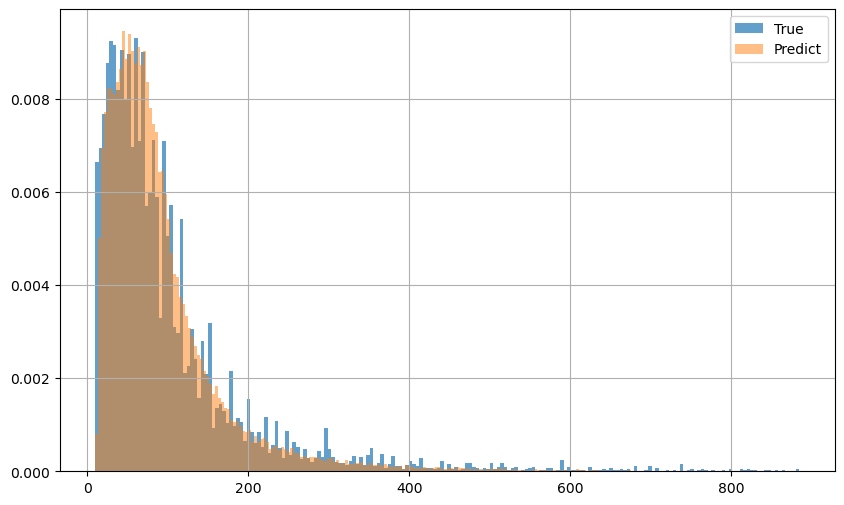

In [98]:
#绘制分布图
fig,ax = plt.subplots(figsize=(10,6))

ax.hist(Y_test,bins=200,density=True,label='True',alpha=0.7)
ax.hist(Y_pred6,bins=200,density=True,label='Predict',alpha=0.5)

ax.legend(loc='upper right')
ax.grid()

plt.show()

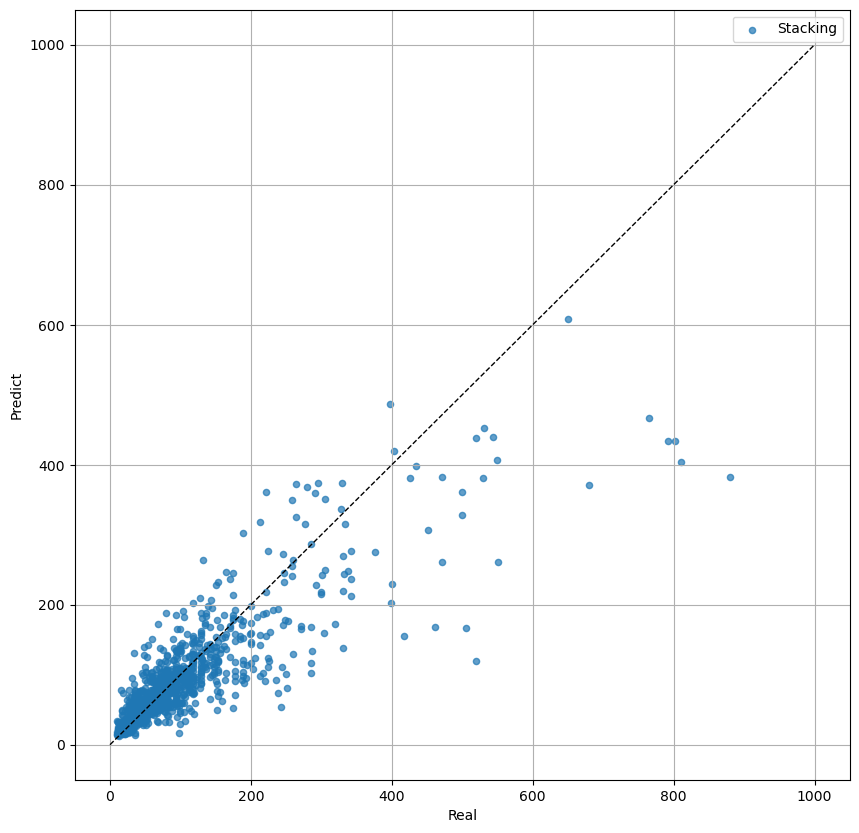

In [99]:
# 绘制预测值和实际值的图
fig,ax = plt.subplots(figsize=(10,10))

ax.scatter(Y_test[0:1000], Y_pred6[0:1000], label='Stacking', s=20, alpha=0.7)
ax.plot((0,1000),(0,1000), '--k', lw=1)

ax.set_xlabel('Real')
ax.set_ylabel('Predict')
ax.legend(loc='upper right')
ax.grid()

plt.show()

## 结果展示
#### (一)RMSE

In [23]:
model_names = ['Xgboost', 'Adaboost','Random Forest','Stacking']
metrics_names = ['In sample', 'Cross-validation', 'Testing','Total N of Predictions after dropping outliers','MAE']

In [24]:
perf = pd.DataFrame(index=model_names, columns=metrics_names)

In [25]:
#Xgboost
Y_pred11 = np.exp(XGB.predict(X_train))
Y_pred12 = np.exp(XGB.predict(X_test))
perf['In sample']['Xgboost'] = mean_squared_error(Y_train,Y_pred11, squared=False)
perf['Cross-validation']['Xgboost'] = np.sqrt(-cross_val_score(XGB,X_train,Y_train,cv = 6, scoring='neg_mean_squared_error')).mean()
perf['Testing']['Xgboost'] = mean_squared_error(Y_test,Y_pred12, squared=False)
perf['Total N of Predictions after dropping outliers']['Xgboost'] = len(X_test)
perf['MAE']['Xgboost'] = mean_absolute_error(Y_test,Y_pred12)

In [54]:
#Adaboost
Y_pred21 = np.exp(Ada.predict(X_train))
Y_pred22 = np.exp(Ada.predict(X_test))
perf['In sample']['Adaboost'] = mean_squared_error(Y_train,Y_pred21, squared=False)
perf['Cross-validation']['Adaboost'] = np.sqrt(-cross_val_score(Ada,X_train,np.array(Y_train).reshape(-1)
                                                                ,cv = 6, scoring='neg_mean_squared_error')).mean()
perf['Testing']['Adaboost'] = mean_squared_error(Y_test,Y_pred22, squared=False)
perf['Total N of Predictions after dropping outliers']['Adaboost'] = len(X_test)
perf['MAE']['Adaboost'] = mean_absolute_error(Y_test,Y_pred22)

In [65]:
#Random Forest
Y_pred31 = np.exp(forest.predict(X_train))
Y_pred32 = np.exp(forest.predict(X_test))
perf['In sample']['Random Forest'] = mean_squared_error(Y_train,Y_pred31, squared=False)
perf['Cross-validation']['Random Forest'] = np.sqrt(-cross_val_score(forest,X_train,np.array(Y_train).reshape(-1)
                                                                     ,cv = 6, scoring='neg_mean_squared_error')).mean()
perf['Testing']['Random Forest'] = mean_squared_error(Y_test,Y_pred32, squared=False)
perf['Total N of Predictions after dropping outliers']['Random Forest'] = len(X_test)
perf['MAE']['Random Forest'] = mean_absolute_error(Y_test,Y_pred32)

In [100]:
#Stacking
Y_pred41 = np.exp(final.predict(X_train))
Y_pred42 = np.exp(final.predict(X_test))
perf['In sample']['Stacking'] = mean_squared_error(Y_train,Y_pred41, squared=False)
perf['Testing']['Stacking'] = mean_squared_error(Y_test,Y_pred42, squared=False)
perf['Total N of Predictions after dropping outliers']['Stacking'] = len(X_test)
perf['MAE']['Stacking'] = mean_absolute_error(Y_test,Y_pred42)

In [102]:
%%time
cv_rmse = 0
kf = KFold(n_splits=6)
for (train,val) in kf.split(X_train,Y_train_log):
    Xtrain = X_train.iloc[train]
    Ytrain = Y_train_log.iloc[train]
    Xval = X_train.iloc[val]
    Yval = Y_train.iloc[val]
    final.fit(Xtrain,np.array(Ytrain).reshape(-1))
    Y_tmp = np.exp(final.predict(Xval))
    cv_rmse += (mean_squared_error(Yval,Y_tmp, squared=False))/6
    print('Finish!')
    
perf['Cross-validation']['Stacking'] = cv_rmse

Finish!
Finish!
Finish!
Finish!
Finish!
Finish!
CPU times: total: 10h 1min 24s
Wall time: 1h 20min 31s


In [103]:
perf

In sample Cross-validation    Testing  \
Xgboost         46.02807        67.239403  65.803234   
Adaboost       88.459199       101.760656  88.348198   
Random Forest  73.833492        72.008984  75.263505   
Stacking       51.028487        67.663265  66.474601   

              Total N of Predictions after dropping outliers        MAE  
Xgboost                                                54807   32.97639  
Adaboost                                               54807  48.244254  
Random Forest                                          54807  38.727257  
Stacking                                               54807  33.347868

## <font color='red'>临时存档点，最后需要删除

In [105]:
joblib.dump(XGB, filename='.\\tmp\\XGB.pkl')
joblib.dump(Ada, filename='.\\tmp\\Ada.pkl')
joblib.dump(forest, filename='.\\tmp\\forest.pkl')
joblib.dump(final, filename='.\\tmp\\final.pkl')

['.\\tmp\\final.pkl']

#### (二)特征重要性

In [ ]:
%%time
shuff = permutation_importance(forest,X_test,Y_test,n_repeats=10,n_jobs=-1,random_state=seed)
feat_import_value_shuff = shuff.importances_mean